In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

class BAFDataset:
    def load_data(self, file_path):
        """
        Load the specified subset of the BAF dataset as a pandas DataFrame.

        Args:
        - subset (str): The subset to load. Choices are 'Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', and 'Variant V'.

        Returns:
        - df (pd.DataFrame): The BAF dataset as a pandas DataFrame.
        """
        ds_name = file_path.split("/")[-1]  # Split the path by "/" and get the last element
        subset = ds_name.split(".")[0]  # Split the filename by "." and get the first element

        if subset not in ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']:
            raise ValueError("Invalid subset type. Choices are 'Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', and 'Variant V'.")

        df = pd.read_csv(file_path).drop('device_fraud_count', axis=1)
        return df

    def train_test_split(self, df, month):
        """
        Split the BAF dataset into train and test sets based on the specified month.

        Args:
        - df (pd.DataFrame): The BAF dataset as a pandas DataFrame.
        - month (int): The month to use as the splitting point. Months 0-5 are in the train set, and 6-7 are in the test set, as proposed in the paper.

        Returns:
        - (X_train, y_train), (X_test, y_test) (tuple of pd.DataFrame): A tuple containing the train and test sets.
        """
        train_mask = df['month'] < month
        X_train, y_train = df[train_mask].drop(['month', 'fraud_bool'], axis=1), df[train_mask]['fraud_bool']
        X_test, y_test = df[~train_mask].drop(['month', 'fraud_bool'], axis=1), df[~train_mask]['fraud_bool']
        return (X_train, y_train), (X_test, y_test)

    def one_hot_encode_categorical(self, X_train, X_test):
        """
        One-hot encode the categorical features in the BAF dataset.

        This function takes the training and test sets as input, identifies the categorical features
        in the dataset, and one-hot encodes them. The one-hot encoding process converts categorical
        features into binary columns for each category/label. This is done separately for the training
        and test sets to avoid data leakage. The transformed data is then combined with the numerical
        features to form the final one-hot encoded train and test sets.

        Args:
        - X_train (pd.DataFrame): The training set features.
        - X_test (pd.DataFrame): The test set features.

        Returns:
        - X_train, X_test (tuple of pd.DataFrame): The one-hot encoded train and test sets.
        """
        # Identify the categorical features
        s = (X_train.dtypes == 'object')
        object_cols = list(s[s].index)

        # Initialize the one-hot encoder with 'ignore' for handling unknown categories in the test set
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        # Apply one-hot encoding to the categorical features in the train and test sets
        ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
        ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

        # Set the index of the transformed data to match the original data
        ohe_cols_train.index = X_train.index
        ohe_cols_test.index = X_test.index

        # Remove the original categorical features from the train and test sets
        num_X_train = X_train.drop(object_cols, axis=1)
        num_X_test = X_test.drop(object_cols, axis=1)

        # Concatenate the numerical features with the one-hot encoded categorical features
        X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
        X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)

        # Ensure the column names are strings to meet newer sklearn requirements
        X_train.columns = X_train.columns.astype(str)
        X_test.columns = X_test.columns.astype(str)

        return X_train, X_test

In [ ]:
!pip install aequitas

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of aequitas to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.4/456.4 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.8/727.8 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from aequitas.group import Group
import pandas as pd

def calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=0.05):
    """
    Calculate the model metrics, including TPR, FPR, threshold and AUROC based on a given FPR limit.

    Args:
    - scored_test (np.array): The predicted scores on the test set.
    - y_test (pd.DataFrame): The test set target variable.
    - fpr_lim (float): The FPR limit to use for obtaining the threshold and TPR. Default is 0.05.

    Returns:
    - metrics_dict (dict): A dictionary containing the TPR, FPR, threshold and AUROC.
    """
    # Calculate the ROC curve points
    fpr, tpr, threshold = roc_curve(y_test, scored_test)

    # Obtain the threshold and TPR based on the FPR
    obtained_tpr = tpr[fpr < fpr_lim][-1]
    obtained_threshold = threshold[fpr < fpr_lim][-1]
    obtained_fpr = fpr[fpr < fpr_lim][-1]

    # Calculate AUROC
    auroc = roc_auc_score(y_test, scored_test)

    # Store the metrics in a dictionary
    metrics_dict = {
        'TPR': round(obtained_tpr, 4),
        'FPR': round(obtained_fpr, 4),
        'Threshold': round(obtained_threshold, 4),
        'AUROC': round(auroc, 4),
    }

    return metrics_dict


def calculate_fairness_metrics(y_test, scored_test, X_test, fpr_lim=0.05):
    """
    Calculate fairness metrics on the predictions.

    Args:
    - scored_test (np.array): The predicted scores on the test set.
    - y_test (pd.Series): The test set target variable.
    - X_test (pd.DataFrame): The test set features.

    Returns:
    - fairness_ratio (float): The fairness ratio.
    """
    # Initialize the fairness evaluator
    g = Group()

    # Calculate the ROC curve points
    fpr, tpr, threshold = roc_curve(y_test, scored_test)

    # Obtain the threshold
    obtained_threshold = threshold[fpr < fpr_lim][-1]

    # Create a DataFrame with the scores, labels, and age
    df = pd.DataFrame({
        "score": scored_test,
        "label_value": y_test,
        "age": (X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})
    })

    # Calculate the fairness metrics
    fairness_metrics = g.get_crosstabs(df, score_thresholds={"score": [obtained_threshold]})[0]

    # Calculate the fairness ratio as the min over max in FPR
    fairness_ratio = fairness_metrics["fpr"].min() / fairness_metrics["fpr"].max()

    return round(fairness_ratio, 4)

In [ ]:
# Import the necessary packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
# from baf import BAFDataset
# from metrics import calculate_tpr_at_fpr, calculate_fairness_metrics
import os
import joblib
import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve
!pip install pytorch-tabnet
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

print(os.environ)
seed = 100
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00
environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.5.3.2-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.5.82-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn9-cuda-12', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.22.3-1+cuda12.5', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.22.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'MODEL_PROXY_HOST': 'https://mp.kaggle.net', 'HOSTNAME': '6665c1eb38df', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.5 brand=unknown,driver>=470,driver<471 brand=grid,driver>=470,driver<471 brand=tesla,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=nvidiartx,

In [ ]:
ds = BAFDataset()

In [ ]:
base_path = "/content/drive/MyDrive/FairFraudDetection/data/raw"
model_path = "/content/drive/MyDrive/FairFraudDetection/models"

variant = "Base.csv"

In [ ]:
# Add file to path
file_path = os.path.join(base_path, variant)

# Load the dataset
df = ds.load_data(file_path)

In [ ]:
# Split the dataset into train and test sets
(X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

In [ ]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w
0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,...,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1
1,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,...,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1
2,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,...,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1
3,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,...,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1
4,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,...,1,26,0,200.0,0,INTERNET,3.743048,other,0,1


In [ ]:
# One-hot encode the categorical features in the dataset
X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

In [ ]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,16,17,18,19,20,21,22,23,24,25
0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# Dictionaries to store training and inference times
training_times_dict = {}
inference_times_dict = {}

In [ ]:
# Create an instance of TabNet model
clf = TabNetClassifier()

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# Create a custom metric class to pass to TabNet
class TPR_at_05FPR(Metric):
    def __init__(self):
        self._name = "tpr_at_05fpr"
        self._maximize = True

    def __call__(self, y_true, y_score):
        fpr, tpr, threshold = roc_curve(y_true, y_score[:, 1])
        tpr_at_05fpr = tpr[fpr < 0.05][-1]
        return tpr_at_05fpr

In [ ]:
# Start measuring training time
start_time = time.time()

# Train TabNet
clf.fit(
    X_train.values,
    y_train.values,
    eval_metric=[TPR_at_05FPR, "auc"],
    max_epochs=5,
    batch_size=512,
    weights=0
)

# End measuring training time
end_time = time.time()

# Storing and printing the time
tabnet_training_time = end_time - start_time
print(f"Training Time: {tabnet_training_time} seconds")
training_times_dict[(variant.split('.')[0], "TabNet")] = {"Training Time":tabnet_training_time}

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.05222 |  0:00:53s
epoch 1  | loss: 0.04621 |  0:02:08s
epoch 2  | loss: 0.04561 |  0:03:31s
epoch 3  | loss: 0.04521 |  0:04:28s
epoch 4  | loss: 0.04494 |  0:05:19s
Training Time: 582.2999150753021 seconds


In [ ]:
# Start measuring inference time
start_time = time.time()

# Predict on the test set
tabnet_scored_test = clf.predict_proba(X_test.values)[:,1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
tabnet_inference_time = end_time - start_time
print(f"Inference Time: {tabnet_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "TabNet")] = {"Inference Time":tabnet_inference_time}

Inference Time: 5.383496046066284 seconds


In [ ]:
clf.save_model("/content/drive/MyDrive/FairFraudDetection/models")

Successfully saved model at /content/drive/MyDrive/FairFraudDetection/models.zip


'/content/drive/MyDrive/FairFraudDetection/models.zip'

In [ ]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, tabnet_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'TabNet')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.5076, Model FPR: 0.05, Model Threshold: 0.04639999940991402, Model AUROC: 0.88


In [ ]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, tabnet_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'TabNet')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Fairness Ratio: 0.9141 



In [ ]:
# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Hyperparameters
input_size = 50  # Number of input features
hidden_size = 30  # Number of neurons in the hidden layer
batch_size = 512
learning_rate = 0.0001
num_epochs = 5

# Create an instance of the Autoencoder
autoencoder = Autoencoder(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [ ]:
# Convert DataFrame to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [ ]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Start measuring training time
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = autoencoder(batch[0])
        loss = criterion(outputs, batch[0])
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# End measuring training time
end_time = time.time()

# Storing and printing the time
ae_training_time = end_time - start_time
print(f"Training Time: {ae_training_time} seconds")
training_times_dict[(variant.split('.')[0], "AE")] = {"Training Time":ae_training_time}

Epoch [1/5], Loss: 116082.0312
Epoch [2/5], Loss: 52273.7539
Epoch [3/5], Loss: 11416.2080
Epoch [4/5], Loss: 1759.7798
Epoch [5/5], Loss: 680.9943
Training Time: 44.90386128425598 seconds


In [ ]:
# Start measuring inference time
start_time = time.time()

# Pass the test data through the autoencoder
with torch.no_grad():
    reconstructed_data = autoencoder(X_test_tensor)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
ae_inference_time = end_time - start_time
print(f"Inference Time: {ae_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "AE")] = {"Inference Time":ae_inference_time}

# Calculate reconstruction errors
reconstruction_errors = ((reconstructed_data - X_test_tensor)**2).mean(dim=1)

# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test.values, reconstruction_errors.numpy(), fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'AE')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, reconstruction_errors.numpy(), X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'AE')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Inference Time: 0.07853579521179199 seconds
Model TPR: 0.0688, Model FPR: 0.0499, Model Threshold: 1875.267822265625, Model AUROC: 0.6276
Fairness Ratio: 0.9134 



In [ ]:
# Unsupservised methods
from deepod.models.dsvdd import DeepSVDD
clf = DeepSVDD()
clf.fit(X_train.values, y=None)
scores = clf.decision_function(X_test.values)

# Weakly-supervised methods
from deepod.models.devnet import DevNet
clf = DevNet()
# semi_y uses 1 for known anomalies and 0 for unlabeled data
# Using y_train.values as semi_y for now, assuming it contains suitable labels.
clf.fit(X_train.values, y=y_train.values)
scores = clf.decision_function(X_test.values)

Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=50, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch1, training loss: 26094.537015, time: 23.4s
epoch10, training loss: 737.767766, time: 23.6s
epoch20, training loss: 406.056404, time: 23.2s
epoch30, training loss: 284.040622, time: 22.9s
epoch40, training loss: 268.300716, time: 22.4s
epoch50, training loss: 201.024412, time: 22.6s
epoch60, training loss: 186.611954, time: 22.1s
epoch70, training loss: 153.202214, time: 22.6s
epoch80, training loss: 141.386857, time: 22.1s
epoch90, training loss: 126.209352, time: 22.7s
epoch100, training loss: 133.316785, time: 22.4s
Start Inference on the 

In [ ]:
!pip install deepod

INFO: pip is looking at multiple versions of deepod to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
from deepod.models.icl import ICL

In [ ]:
# unsupervised method
clf = ICL(epochs=5)

In [ ]:
# Start measuring training time
start_time = time.time()

# Train ICL
clf.fit(X_train.values, y=None)

# End measuring training time
end_time = time.time()

# Storing and printing the time
icl_training_time = end_time - start_time
print(f"Training Time: {icl_training_time} seconds")

Start Training...
ensemble size: 2
kernel size: 10
ICLNet(
  (enc_f_net): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=40, out_features=100, bias=False)
        (act_layer): Tanh()
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (1): LinearBlock(
        (linear): Linear(in_features=100, out_features=50, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (2): LinearBlock(
        (linear): Linear(in_features=50, out_features=128, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
    )
  )
  (enc_g_net): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=10, out_features=50, bias=

In [ ]:
# Start measuring inference time
start_time = time.time()

# Predict on the test set
icl_scored_test = clf.decision_function(X_test.values)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
icl_inference_time = end_time - start_time
print(f"Inference Time: {icl_inference_time} seconds")

Inference Time: 15.603586196899414 seconds


In [ ]:
torch.save(clf.net.state_dict(), "/content/drive/MyDrive/FairFraudDetection/models")

In [ ]:
training_times_dict[(variant.split('.')[0], "ICL")] = {"Training Time":icl_training_time}
inference_times_dict[(variant.split('.')[0], "ICL")] = {"Inference Time":icl_inference_time}

In [ ]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, icl_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'ICL')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.0928, Model FPR: 0.0498, Model Threshold: 2.8338, Model AUROC: 0.539


In [ ]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, icl_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'ICL')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Fairness Ratio: 0.9912 



In [ ]:
# Create a DataFrame from all results
df_performance_results = pd.DataFrame(performance_results).transpose()
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_training_times_dict = pd.DataFrame(training_times_dict).transpose()
df_inference_times_dict = pd.DataFrame(inference_times_dict).transpose()

In [ ]:
# concatenate all results together
all_results = pd.concat([df_performance_results, df_fairness_results, df_training_times_dict, df_inference_times_dict], axis=1)

In [ ]:
all_results

TPR     FPR    Threshold   AUROC  Fairness Ratio  \
Base TabNet  0.5076  0.0500     0.046400  0.8800          0.9141   
     AE      0.0688  0.0499  1875.267822  0.6276          0.9134   
     ICL     0.0928  0.0498     2.833800  0.5390          0.9912   

             Training Time  Inference Time  
Base TabNet     582.299915        5.383496  
     AE          44.903861        0.078536  
     ICL        724.572217       15.603586

In [ ]:
# Extract TPR values
tabnet_tpr = df_performance_results.loc[(variant.split('.')[0], 'TabNet'), 'TPR']
ae_tpr = df_performance_results.loc[(variant.split('.')[0], 'AE'), 'TPR']
icl_tpr = df_performance_results.loc[(variant.split('.')[0], 'ICL'), 'TPR']
tpr_values = [tabnet_tpr, ae_tpr, icl_tpr]

In [ ]:
# Extract Fairness Ratio values
tabnet_fn = df_fairness_results.loc[(variant.split('.')[0], 'TabNet'), 'Fairness Ratio']
ae_fn = df_fairness_results.loc[(variant.split('.')[0], 'AE'), 'Fairness Ratio']
icl_fn = df_fairness_results.loc[(variant.split('.')[0], 'ICL'), 'Fairness Ratio']
fn_values = [tabnet_fn, ae_fn, icl_fn]

In [ ]:
# Extract Training Time values
tabnet_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'TabNet'), 'Training Time']
ae_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'AE'), 'Training Time']
icl_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'ICL'), 'Training Time']
tnt_values = [tabnet_tnt, ae_tnt, icl_tnt]

In [ ]:
# Extract Inference Time values
tabnet_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'TabNet'), 'Inference Time']
ae_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'AE'), 'Inference Time']
icl_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'ICL'), 'Inference Time']
inf_values = [tabnet_inf, ae_inf, icl_inf]

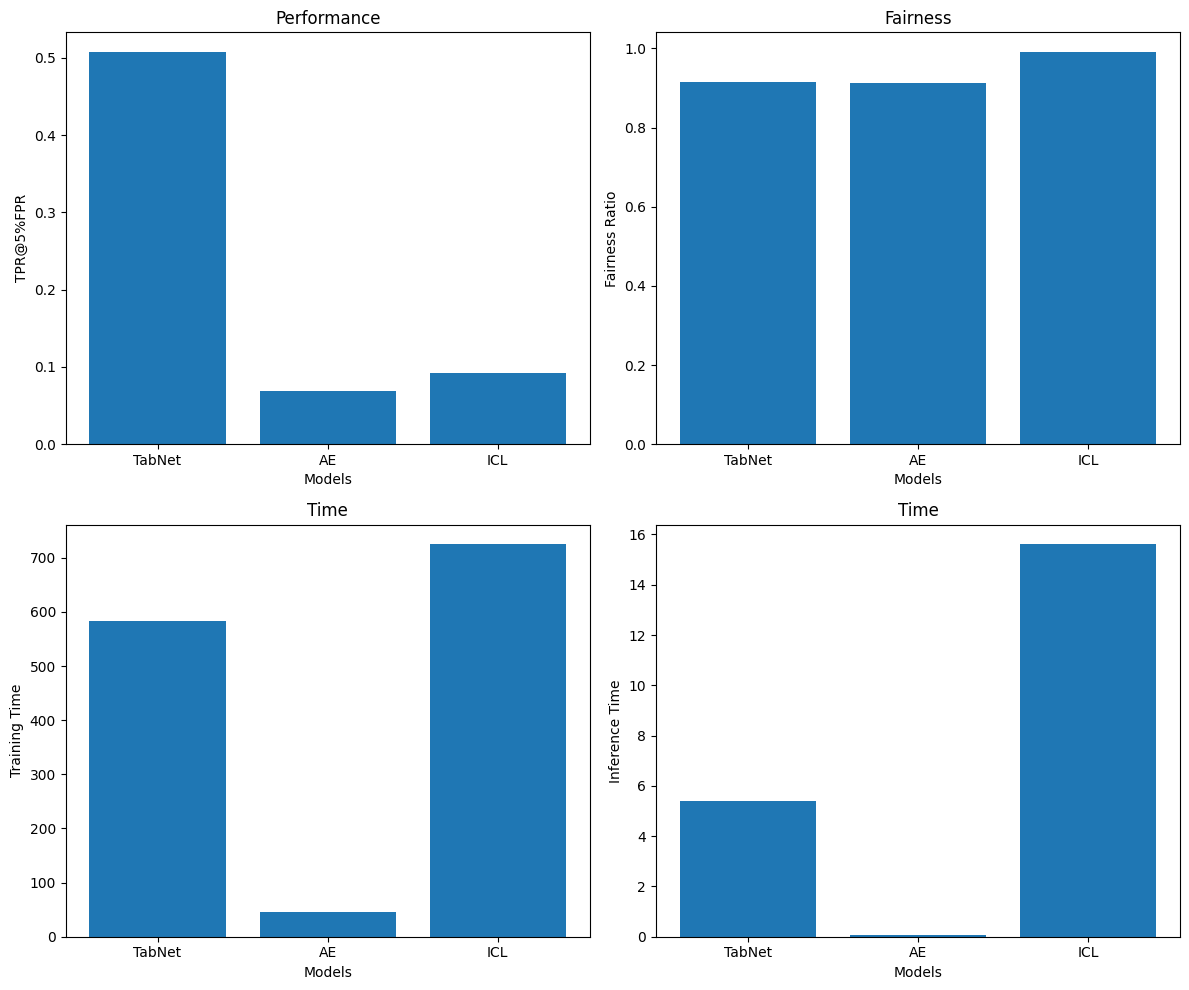

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

models = ['TabNet', 'AE', 'ICL']

# Plot TPR values
axs[0, 0].bar(models, tpr_values)
axs[0, 0].set_xlabel('Models')
axs[0, 0].set_ylabel('TPR@5%FPR')
axs[0, 0].set_title('Performance')

# Plot Fairness Ratio values
axs[0, 1].bar(models, fn_values)
axs[0, 1].set_xlabel('Models')
axs[0, 1].set_ylabel('Fairness Ratio')
axs[0, 1].set_title('Fairness')

# Plot Training Time values
axs[1, 0].bar(models, tnt_values)
axs[1, 0].set_xlabel('Models')
axs[1, 0].set_ylabel('Training Time')
axs[1, 0].set_title('Time')

# Plot Inference Time values
axs[1, 1].bar(models, inf_values)
axs[1, 1].set_xlabel('Models')
axs[1, 1].set_ylabel('Inference Time')
axs[1, 1].set_title('Time')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

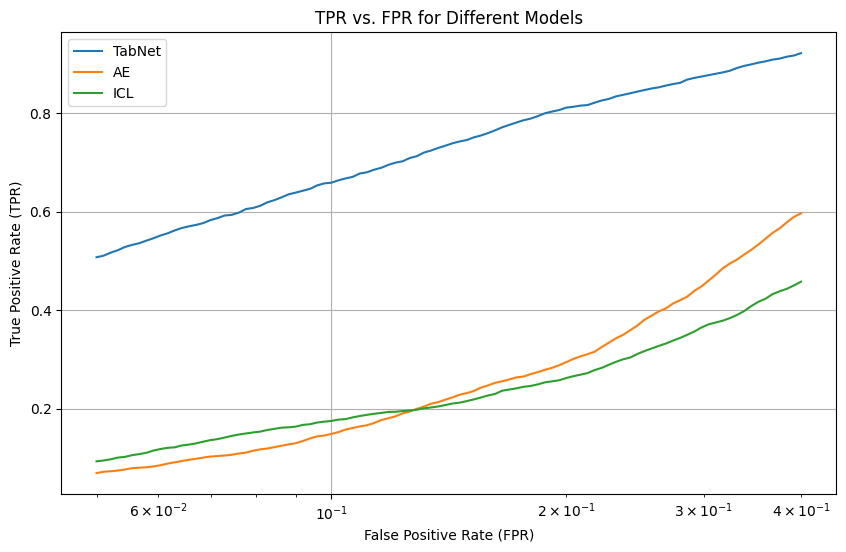

In [ ]:
# Define the list of model names and their corresponding y_scores
model_names = ['TabNet', 'AE', 'ICL']
y_scores_dict = {
    'TabNet': tabnet_scored_test,
    'AE': reconstruction_errors.numpy(),
    'ICL': icl_scored_test,
}

# Generate FPR values from 5% to 40%
fpr_values = np.logspace(np.log10(0.05), np.log10(0.4), num=100)

# Initialize a dictionary to store interpolated TPR values for each model
interpolated_tpr = {}

# Calculate TPR values for each model at the desired FPR points
for model_name in model_names:
    scored_test = y_scores_dict[model_name]
    tpr_list = [calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=i)['TPR'] for i in fpr_values]
    interpolated_tpr[model_name] = tpr_list

# Plotting
plt.figure(figsize=(10, 6))
for model_name, model_tpr_interp in interpolated_tpr.items():
    plt.plot(fpr_values, model_tpr_interp, label=model_name)

plt.xscale('log')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR vs. FPR for Different Models')
plt.legend()
plt.grid(True)
plt.show()